In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import os
import collections
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pymir import mpl_stylesheet
from pymir import mpl_utils
from pymir import pd_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

In [2]:
dscout = pd.read_pickle("../dsc/results/linreg_indep_dscout.pkl")

In [3]:
# methods in the simulation

dims = [(50, 10000),]
sfix = [1, 2, 5, 10, 20,]
method_groups = {
    'PLR': ["ridge", "lasso", "elastic_net", 
            "lasso_1se", "elastic_net_1se", 
            "scad", "mcp", "l0learn"],
    'Sampling': ["blasso", "bayesb"],
    'CAVI': ["mr_ash", "mr_ash_lasso_init", "varbvs", "varbvsmix", "susie"],
    'GradVI': ["gradvi_direct", "gradvi_compound"],
}

In [4]:
# method_groups = {
#     'PLR': ["ridge", "lasso"],
#     'CAVI': ["mr_ash",],
#     'GradVI': ["gradvi_direct", "gradvi_compound"],
# }

methods = [method for k, v in method_groups.items() for method in v]

In [5]:
dscout

,DSC,simulate,simulate.dims,simulate.se,simulate.rho,simulate.sfix,simulate.pve,fit,fit.DSC_TIME,mse.err,coef_mse.err
0,1,equicorrgauss,"(500,10000)",0.615635,0,1,0.4,susie,11.978,0.381405,NaN
1,1,equicorrgauss,"(500,10000)",3.165824,0,2,0.4,susie,14.510,10.878477,NaN
2,1,equicorrgauss,"(500,10000)",2.906543,0,5,0.4,susie,12.660,8.510282,NaN
3,1,equicorrgauss,"(500,10000)",2.234618,0,10,0.4,susie,15.675,5.473055,NaN
4,1,equicorrgauss,"(500,10000)",6.718919,0,20,0.4,susie,20.271,57.600500,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5095,10,equicorrgauss,"(500,10000)",0.061956,0,1,0.8,l0learn,25.538,NaN,2.993806e-10
5096,10,equicorrgauss,"(500,10000)",0.349102,0,2,0.8,l0learn,23.217,NaN,7.787907e-07
5097,10,equicorrgauss,"(500,10000)",1.330043,0,5,0.8,l0learn,19.683,NaN,1.138709e-05
5098,10,equicorrgauss,"(500,10000)",1.169124,0,10,0.8,l0learn,21.903,NaN,8.751058e-06


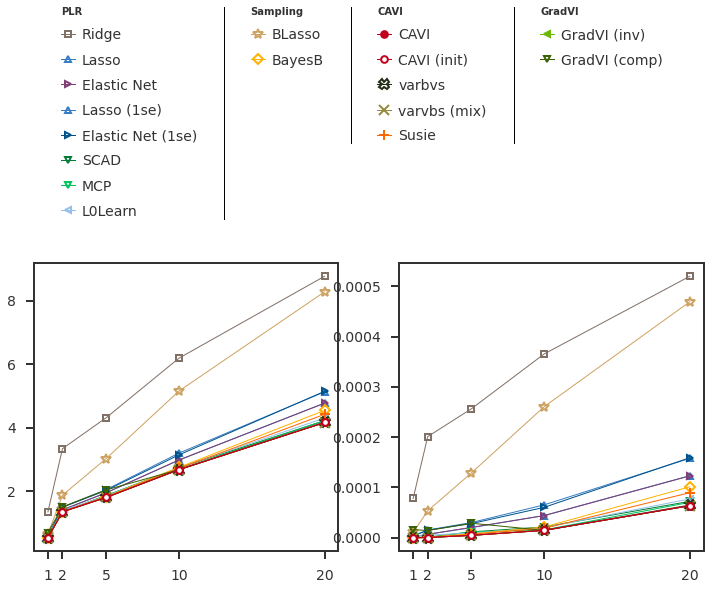

In [7]:
import methodprops

def stratify_dfcol(df, colname, value):
    return df.loc[df[colname] == value]
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])

def single_plot_score_methods(ax, resdf, colname, methods, sfix):
    plotmeta = methodprops.plot_metainfo()
    xscale   = 'linear'
    yscale   = 'linear'
    xvals    = [x for x in sfix]
    for method in methods:
        pm  = plotmeta[method]
        dfm = stratify_dfcol(resdf, 'fit', method)
        dfm = stratify_dfcol(dfm, 'simulate.pve', 0.6)
        #mconditions = [f"$(fit) == {method}"]
        #dfm = pd_utils.select_dfrows(resdf, mconditions)
        dfs = dfm[~dfm[colname].isnull()]
        score = [0 for x in sfix]
        for i, s in enumerate(sfix):
            #sfix_cond = [f"$(simulate.sfix) == {s}"]
            #dfselect = pd_utils.select_dfrows(dfs, sfix_cond)
            dfselect = stratify_dfcol(dfs, 'simulate.sfix', s)
            score[i] = np.mean(dfselect[colname].to_numpy() / dfselect['simulate.se'].to_numpy())

        ax.plot(
            mpl_utils.scale_array(xvals, xscale), 
            mpl_utils.scale_array(score, yscale), 
            label = pm.label, color = pm.color, lw = pm.linewidth / 2, 
            ls = pm.linestyle, marker = pm.marker, ms = pm.size / 1.2, 
            mec = pm.color, mfc = pm.facecolor, mew = pm.linewidth,
            zorder = pm.zorder)
        ax.set_xticks(sfix)
        ax.set_xticklabels([f"{s:d}" for s in sfix])
        
    return

def axis_with_legend_columns(
    fig, ax, method_groups, mhandles, mlabels, 
    frameon = False, show_axes = False, xpad = 0.04
    ):
    #
    renderer = fig.canvas.get_renderer()
    ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
    plotmeta = methodprops.plot_metainfo()
    ncol     = len(method_groups)
    xleg     = 0
    
    for k, (group, methods) in enumerate(method_groups.items()):
        _idx     = [mlabels.index(plotmeta[m].label) for m in methods]
        _labels  = [mlabels[i]  for i in _idx]
        _handles = [mhandles[i] for i in _idx]
        
        legend = ax.legend(
            handles = _handles, labels = _labels, title = group,
            title_fontproperties={'weight':'bold'},
            loc = 'upper left', bbox_to_anchor = (xleg + xpad, 1.0),
            frameon = frameon, framealpha = 1.0, borderpad = 0.0, borderaxespad = 0.0
        )
        
        # align column titles to left
        legend._legend_box.align = "left"

        # corners should be square (not round)
        legend.get_frame().set_boxstyle('square', pad = 0.0)

        # add artist for all but last legend
        if k < ncol - 1:
            ax.add_artist(legend)

        # Get width of the legend
        fig.canvas.draw()
        legbbox = legend.get_window_extent(renderer).transformed(ax.transAxes.inverted())

        # Plot a vertical line to the left
        if k > 0:
            maxh = max(legheight, legbbox.height)
            ax.axvline (xleg, ymin = 1 - maxh, ymax = 1.0, lw = 1, color = 'black')

        xleg += legbbox.width + xpad * 2
        legheight = legbbox.height
    
    if not show_axes:
        mpl_utils.decorate_axes(ax, hide = ["all"], ticklimits = False)
    else:
        for side in ['top', 'bottom', 'left', 'right']:
            ax.spines[side].set_linewidth(1.0)  # change width
    return


scores = ['mse.err', 'coef_mse.err']
figw = 12
figh = 10
nrow = 1
ncol = 2
leg_hprop = 0.8
wspace = 0.2
hspace = 0.1

fig = plt.figure(figsize = (figw, figh))
gs  = gridspec.GridSpec(nrow + 1, ncol, height_ratios = [leg_hprop] + [1 for x in range(nrow)])
gs.update(wspace = wspace, hspace = hspace)

axl = []
for i, score in enumerate(scores):
    ax = fig.add_subplot(gs[1, i])
    single_plot_score_methods(ax, dscout, score, methods, sfix)
    axl.append(ax)
    
# Legend
ax0 = fig.add_subplot(gs[0, :])
mhandles, mlabels = axl[0].get_legend_handles_labels()
axis_with_legend_columns(fig, ax0, method_groups, mhandles, mlabels, show_axes=False)

plt.show()

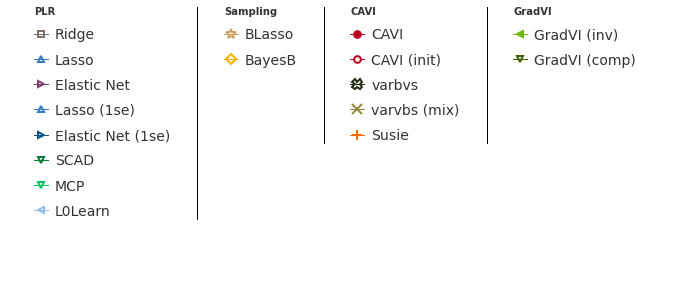

In [16]:
fig = plt.figure(figsize = (12, 5))
axl10 = fig.add_subplot(111)

axis_with_legend_columns(fig, axl10, method_groups, mhandles, mlabels, show_axes = False)
plt.show()

In [19]:
# fig = plt.figure(figsize = (12, 2))
# renderer = fig.canvas.get_renderer()

# axleg = fig.add_subplot(111)
# axleg.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
# plotmeta = methodprops.plot_metainfo()

# #gmlegends = [None for x in method_groups.items()]
# ngroup = len(method_groups)
# xleg = 0
# for k, (group, methods) in enumerate(method_groups.items()):
#     print (group)
#     print (methods)
#     _gmidx     = [mlabels.index(plotmeta[m].label) for m in methods]
#     _gmlabels  = [mlabels[i] for i in _gmidx]
#     _gmhandles = [mhandles[i] for i in _gmidx]
#     print ("upper left at", xleg)
#     legend = axleg.legend(
#         handles = _gmhandles, labels = _gmlabels, title = group,
#         loc = 'upper left', bbox_to_anchor = (xleg, 1.0),
#         frameon = False, framealpha = 1.0, borderpad = 1.0, borderaxespad = 0.0
#     )
#     # align titles to left
#     legend._legend_box.align = "left"
    
#     # square corners
#     legend.get_frame().set_boxstyle('square', pad = 0.0)
    
#     # add artist for all but last legend
#     if k < ngroup - 1:
#         axleg.add_artist(legend)
    
#     # Get width of the legend
#     fig.canvas.draw()
#     legbbox = legend.get_window_extent(renderer).transformed(axleg.transAxes.inverted())
    
#     # Plot a vertical line to the left
#     if k > 0:
#         maxh = max(legheight, legbbox.height)
#         axleg.axvline (xleg, ymin = 1 - maxh, ymax = 1.0, lw = 1, color = 'black')
        
#     xleg += legbbox.width
#     legheight = legbbox.height
    
#     print(lgbbox.width, lgbbox.height)
#     #xleg += lgbbox.width
    
# #mpl_utils.decorate_axes(axleg, hide = ["all"], ticklimits = False)
# plt.show()